#GE-461 Project 2

##Preprocess

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy.stats import multivariate_normal
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

In [ ]:
# Authenticate and mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/GE-461/fashion_data"

fashion_mnist_data.txt	fashion_mnist_labels.txt


In [ ]:
# Function to read pixel data from the dataset
def read_pixels(data_path):
    with open(data_path, 'r') as f:
        pixel_data = np.loadtxt(f)
    # Rotate images by 90 degrees clockwise
    pixel_data = np.rot90(pixel_data.reshape(-1, 28, 28), k=3, axes=(1, 2))
    pixel_data = pixel_data.reshape(-1, 784)
    return pixel_data

# Function to read label data from the dataset
def read_labels(data_path):
    with open(data_path, 'r') as f:
        label_data = np.loadtxt(f)
    return label_data



Combine the datasets(train and test)

In [ ]:
# Path to the directory containing fashion_mnist.zip
data_path = "/content/drive/MyDrive/GE-461/fashion_data"

# Extracting pixel and label data
X = read_pixels(data_path + "/fashion_mnist_data.txt")
y = read_labels(data_path + "/fashion_mnist_labels.txt")

In [ ]:
X.shape

(10000, 784)

Separate the data 50/50 (train,test)

In [ ]:
# Identify unique classes in the dataset
classes = np.unique(y)

# Initialize lists to store indices of samples for training and testing
train_indices = []
test_indices = []

# Randomly select half of the samples from each class for training and the remaining for testing
for cls in classes:
    # Get indices of samples belonging to the current class
    cls_indices = np.where(y == cls)[0]

    # Split the indices into train and test
    cls_train_indices, cls_test_indices = train_test_split(cls_indices, test_size=0.5, random_state=42)

    # Append the indices to the global train and test lists
    train_indices.extend(cls_train_indices)
    test_indices.extend(cls_test_indices)

# Convert lists of indices to arrays
train_indices = np.array(train_indices)
test_indices = np.array(test_indices)

# Split the dataset into training and testing subsets
X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

In [ ]:
test_indices

array([5129, 7575, 7590, ..., 4458, 8767, 8876])

Observe some instances

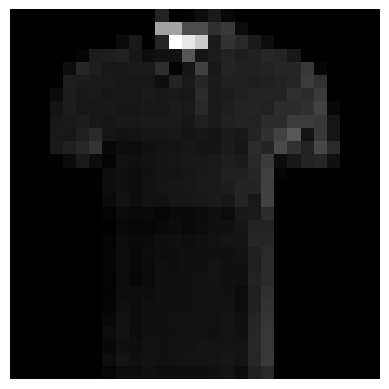

0.0


In [ ]:
instance_index = 4
# Reshape the flattened array into a 2D array (28x28)
image_array = X_test[instance_index].reshape(28, 28)

# Display the image using matplotlib
plt.imshow(image_array, cmap='gray')
plt.axis('off')  # Turn off axis
plt.show()

print(y_test[instance_index])

It looks accurate. Let's start with PCA

##Question 1

Center the data

In [ ]:
X_train_centered = X_train - np.mean(X_train, axis=0)
X_test_centered = X_test- np.mean(X_test, axis=0)

 Performing PCA

###Step 1, 2

In [ ]:
def pca_projection(X, num_components):
    pca = PCA(n_components=num_components)
    projected_data = pca.fit_transform(X)
    return projected_data, pca.components_, pca.explained_variance_, pca.explained_variance_ratio_

In [ ]:
projected_data, selected_eigenvectors, eigenvalues, explained_variance_ratio = pca_projection(X_train_centered, num_components=100)
sorted_eigenvalues = np.sort(eigenvalues)[::-1]

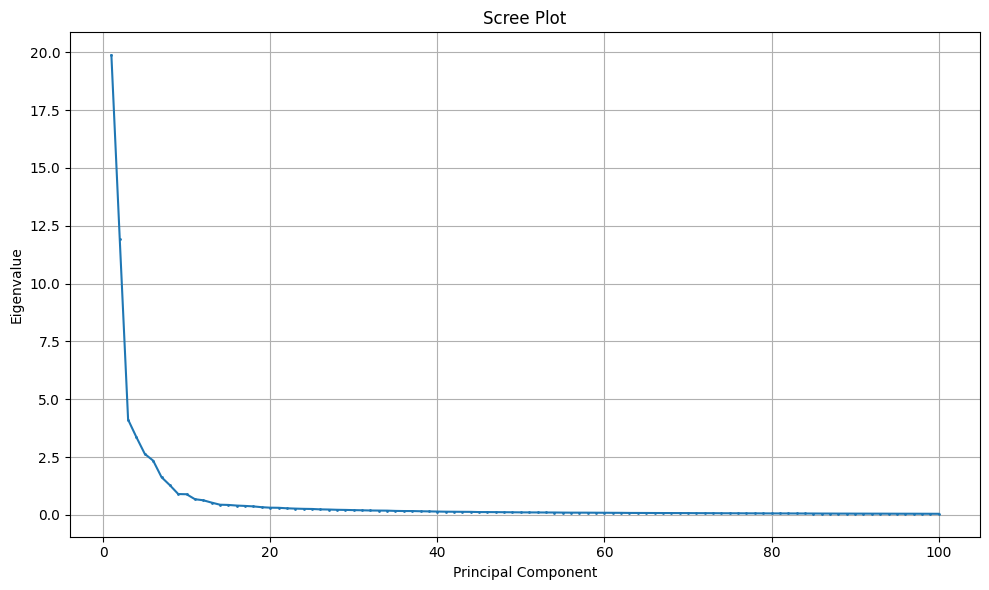

In [ ]:
# Plot the eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(sorted_eigenvalues) + 1), sorted_eigenvalues, marker='o', markersize=1, linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

Approxiately 10 components seem appropriate.

###Step 3

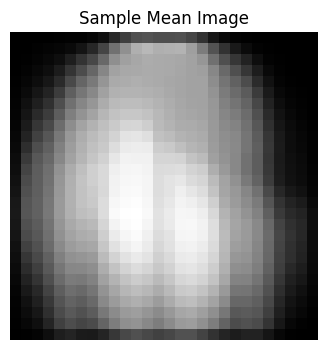

In [ ]:
# Sample mean for the whole training dataset
sample_mean = np.mean(X_train, axis=0)

# Reshape the sample mean to match the image dimensions
sample_mean_image = sample_mean.reshape(28, 28)

# Display the sample mean image
plt.figure(figsize=(4, 4))
plt.imshow(sample_mean_image, cmap='gray')
plt.title('Sample Mean Image')
plt.axis('off')
plt.show()

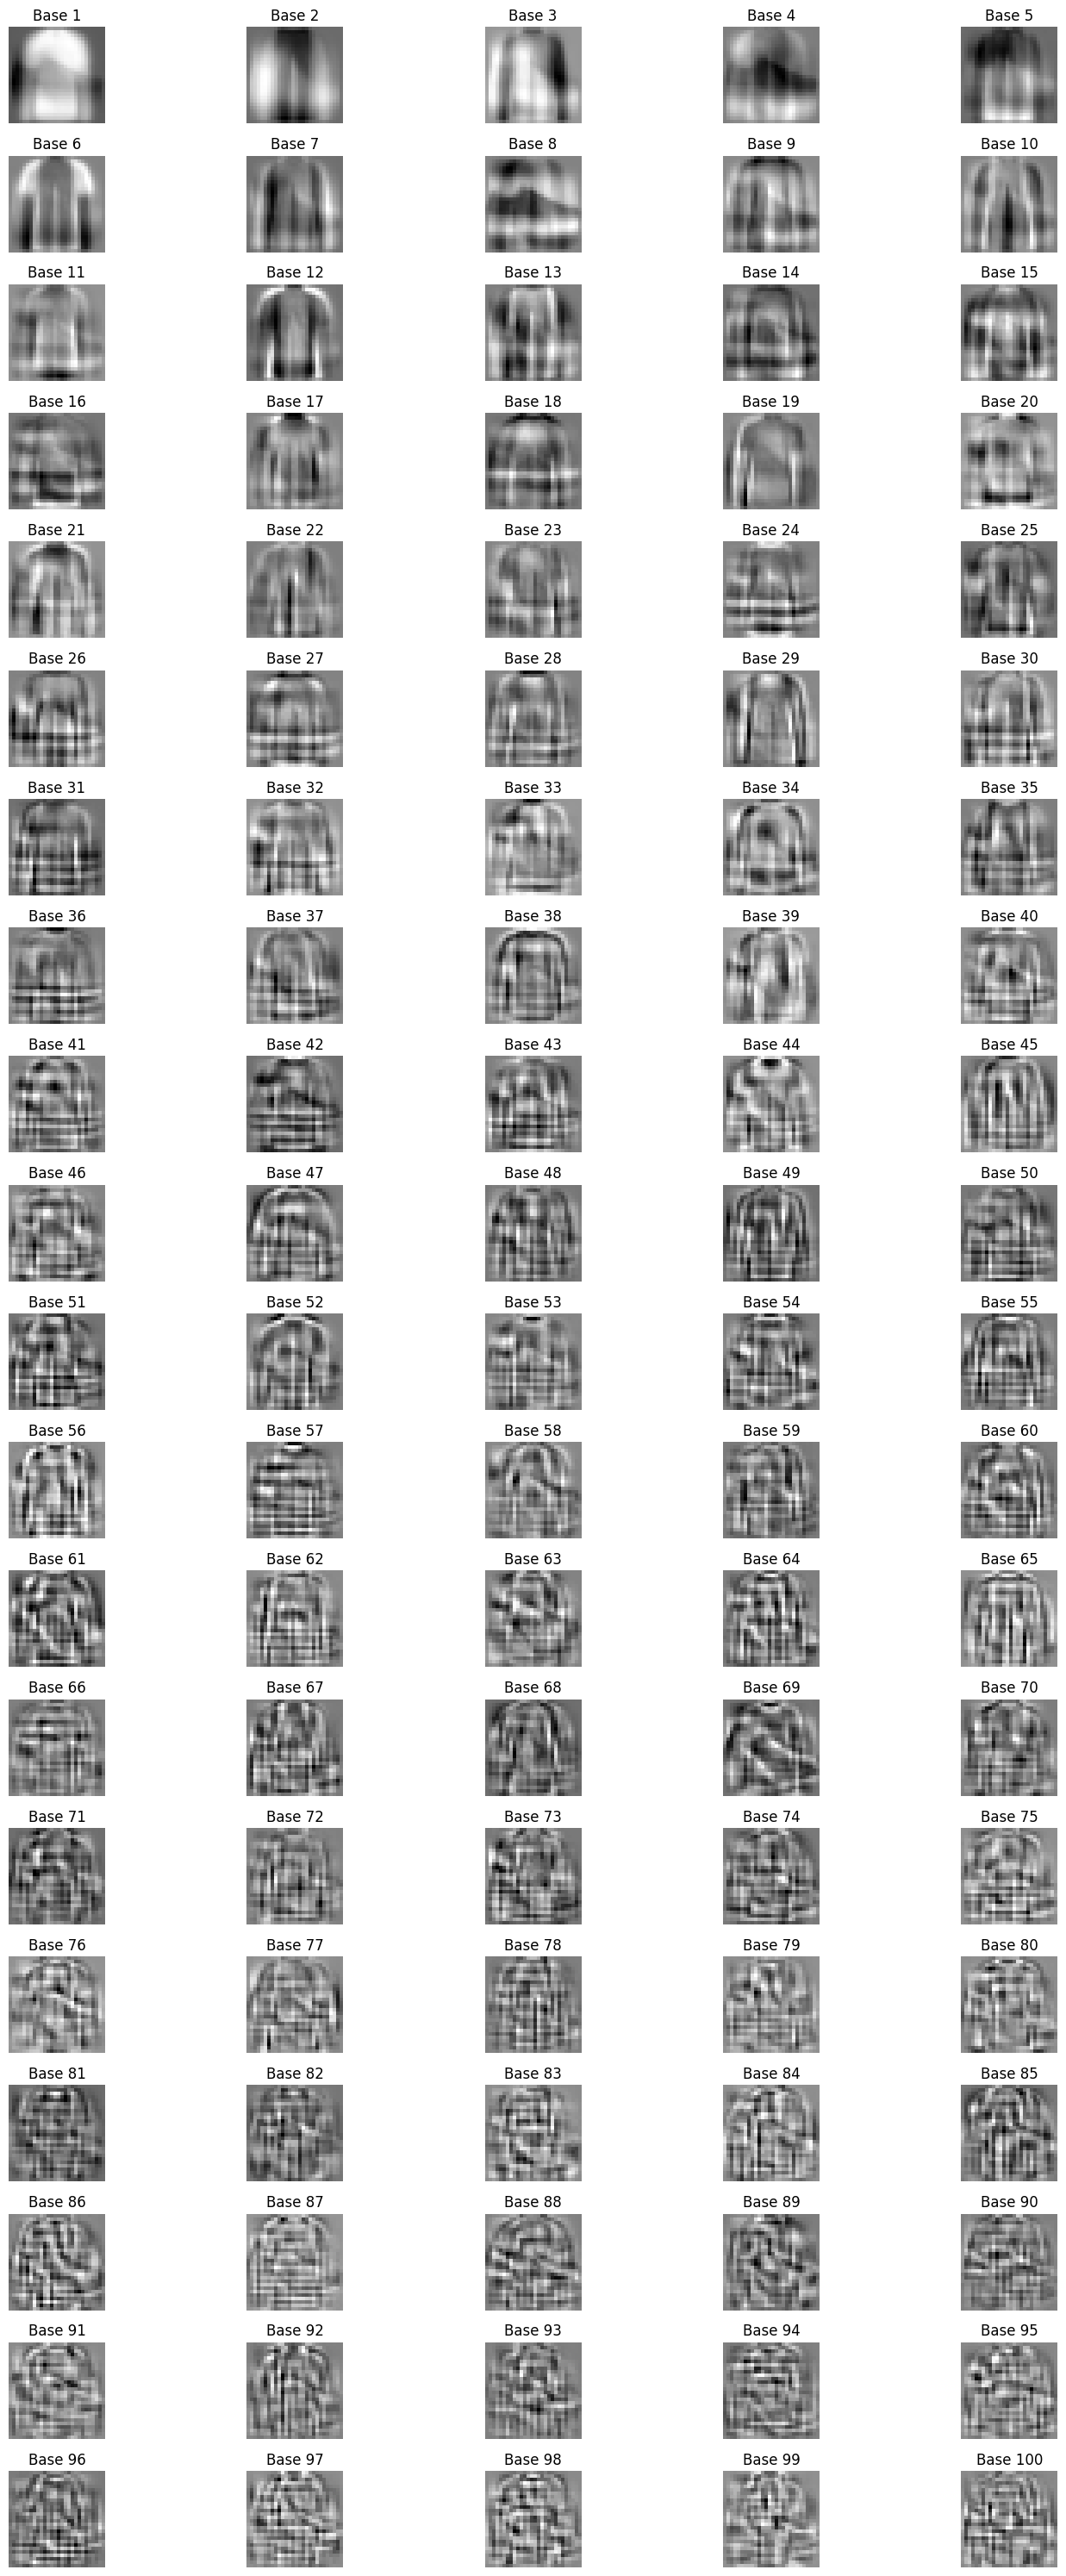

In [ ]:
# Assuming selected_eigenvectors contains the selected eigenvectors obtained from PCA
num_bases_to_display = 100
plt.figure(figsize=(15, 30))
for i in range(num_bases_to_display):
    plt.subplot(int(num_bases_to_display/5), 5, i+1)
    base_image = selected_eigenvectors[i].reshape(28, 28)  # Reshape the eigenvector to 28x28
    plt.imshow(base_image, cmap='gray')
    plt.title(f'Base {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

After base 10, it does not seem that PCA algorithm gains too much information from the additional dimensions. Therefore, around 10 still seems appropriate.

###Step 4

In [ ]:
# Define a range of subspace dimensions
subspace_dimensions = range(1, 400, 16)  # Choose at least 25 different subspace dimensions

In [ ]:
# Initialize lists to store projected data for training and test sets
pca_projected_data_train = []
pca_projected_data_test = []

# Iterate over each subspace dimension
for dim in subspace_dimensions:
    # Project training data onto the subspace
    pca = PCA(n_components=dim)
    projected_train = pca.fit_transform(X_train_centered)
    pca_projected_data_train.append(projected_train)

    # Project test data onto the same subspace using the transformation matrix estimated from the training data
    projected_test = pca.transform(X_test_centered)
    pca_projected_data_test.append(projected_test)

In [ ]:
def gaussian_classifier_train(X_train, y_train):
    unique_classes = np.unique(y_train)
    num_classes = len(unique_classes)
    class_means = np.zeros((num_classes, X_train.shape[1]))
    class_covs = np.zeros((num_classes, X_train.shape[1], X_train.shape[1]))

    # Compute class means, and covariances
    for c in range(num_classes):
        X_c = X_train[np.where(y_train == c)[0]]
        class_means[c] = np.mean(X_c, axis=0)
        class_covs[c] = np.cov(X_c.T)

    return class_means, class_covs

def gaussian_classifier_predict(X_test, class_means, class_covs):
    num_classes = len(class_means)
    num_samples = X_test.shape[0]

    posteriors = np.zeros((num_samples, num_classes))

    for c in range(num_classes):
        mean = class_means[c]
        cov = class_covs[c]
        cov_regularized = cov + 1e-3 * np.eye(cov.shape[0])
        mvn = multivariate_normal(mean=mean, cov=cov_regularized)
        posteriors[:, c] = mvn.pdf(X_test)

    y_pred = np.argmax(posteriors, axis=1)

    return y_pred


In [ ]:
# Initialize lists to store accuracy scores
accuracy_scores_test = []
accuracy_scores_train = []

# Iterate over each pair of projected training and test data
for projected_train, projected_test in zip(pca_projected_data_train, pca_projected_data_test):

    # Train the Gaussian classifier
    class_means, class_covs = gaussian_classifier_train(projected_train, y_train)
    # Make predictions on the test set
    y_pred_test = gaussian_classifier_predict(projected_test, class_means, class_covs)
    y_pred_train = gaussian_classifier_predict(projected_train, class_means, class_covs)
    print(projected_train.shape)

    # Calculate accuracy and store it
    accuracy1 = accuracy_score(y_test, y_pred_test)
    accuracy_scores_test.append(accuracy1)

    accuracy2 = accuracy_score(y_train, y_pred_train)
    accuracy_scores_train.append(accuracy2)


(5000, 1)
(5000, 17)
(5000, 33)
(5000, 49)
(5000, 65)
(5000, 81)
(5000, 97)
(5000, 113)
(5000, 129)
(5000, 145)
(5000, 161)
(5000, 177)
(5000, 193)
(5000, 209)
(5000, 225)
(5000, 241)
(5000, 257)
(5000, 273)
(5000, 289)
(5000, 305)
(5000, 321)
(5000, 337)
(5000, 353)
(5000, 369)
(5000, 385)


In [ ]:
# Calculate classification errors for training and test sets
pca_projection_test_errors = 1 - np.array(accuracy_scores_test)
pca_projection_train_errors = 1 - np.array(accuracy_scores_train)

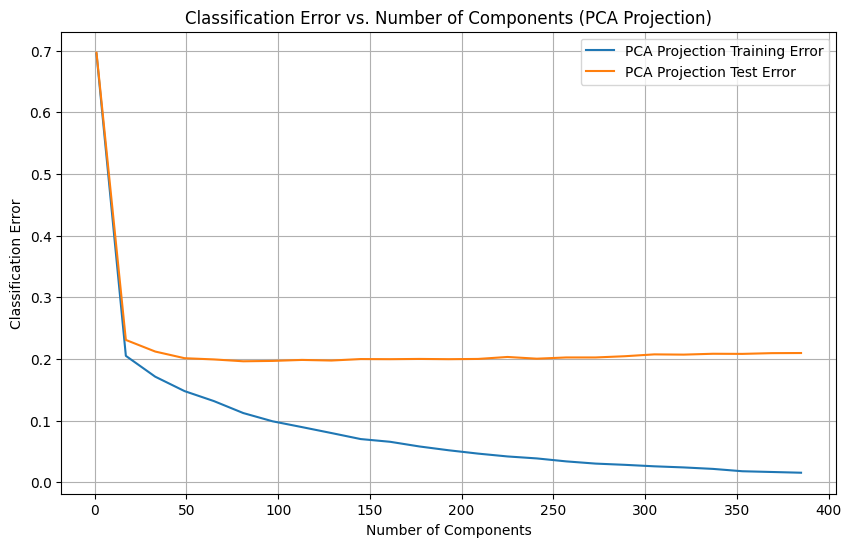

In [ ]:
# Plot classification errors vs. number of components for random projections
plt.figure(figsize=(10, 6))
plt.plot(subspace_dimensions, pca_projection_train_errors, label='PCA Projection Training Error')
plt.plot(subspace_dimensions, pca_projection_test_errors, label='PCA Projection Test Error')
plt.title('Classification Error vs. Number of Components (PCA Projection)')
plt.xlabel('Number of Components')
plt.ylabel('Classification Error')
plt.legend()
plt.grid(True)
plt.show()

##Question 2

Do the same application with random projection instead of PCA

In [ ]:
# Initialize lists to store projected data for training and test sets
random_projected_data_train = []
random_projected_data_test = []

# Iterate over each subspace dimension
for dim in subspace_dimensions:
    # Generate a random projection matrix
    random_projection_matrix = np.random.rand(784, dim)

    # Project training and test data onto the subspace using random projection
    random_projected_train = np.dot(X_train, random_projection_matrix)
    random_projected_test = np.dot(X_test, random_projection_matrix)

    # Append the projected data to the lists
    random_projected_data_train.append(random_projected_train)
    random_projected_data_test.append(random_projected_test)

In [ ]:
# Initialize lists to store accuracy scores
random_accuracy_scores_test = []
random_accuracy_scores_train = []

# Iterate over each pair of projected training and test data
for random_projected_train, random_projected_test in zip(random_projected_data_train, random_projected_data_test):

    # Train the Gaussian classifier
    random_class_means, random_class_covs = gaussian_classifier_train(random_projected_train, y_train)

    # Make predictions on the test set
    random_y_pred_test = gaussian_classifier_predict(random_projected_test, random_class_means, random_class_covs)
    random_y_pred_train = gaussian_classifier_predict(random_projected_train, random_class_means, random_class_covs)

    # Calculate accuracy and store it
    random_accuracy1 = accuracy_score(y_test, random_y_pred_test)
    random_accuracy_scores_test.append(random_accuracy1)

    random_accuracy2 = accuracy_score(y_train, random_y_pred_train)
    random_accuracy_scores_train.append(random_accuracy2)

In [ ]:
# Calculate classification errors for training and test sets
random_projection_test_errors = 1 - np.array(random_accuracy_scores_test)
random_projection_train_errors = 1 - np.array(random_accuracy_scores_train)

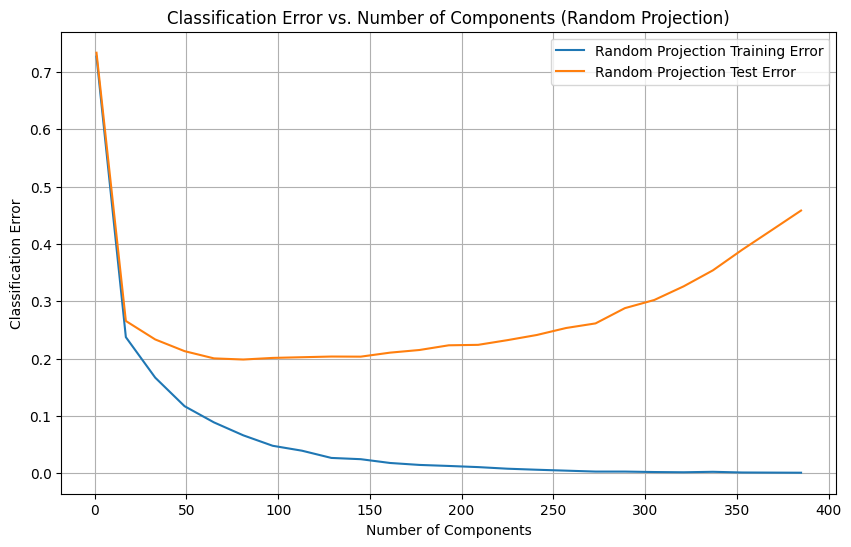

In [ ]:
# Plot classification errors vs. number of components for random projections
plt.figure(figsize=(10, 6))
plt.plot(subspace_dimensions, random_projection_train_errors, label='Random Projection Training Error')
plt.plot(subspace_dimensions, random_projection_test_errors, label='Random Projection Test Error')
plt.title('Classification Error vs. Number of Components (Random Projection)')
plt.xlabel('Number of Components')
plt.ylabel('Classification Error')
plt.legend()
plt.grid(True)
plt.show()

##Question 3

Tried n_neighbors = 5  checked the Difference between the train and tesst errors

In [ ]:
# Initialize lists to store projected data for training and test sets
isomap_projected_data_train = []
isomap_projected_data_test = []

# Define parameters
n_neighbors = 10  # Number of neighbors
eigen_solver = 'arpack'  # Eigen solver method
path_method = 'D'  # Path computation method
neighbors_algorithm = 'ball_tree'  # Nearest neighbors algorithm



# Iterate over each subspace dimension
for dim in subspace_dimensions:
    # Create an instance of the Isomap class
    isomap = Isomap(n_components=dim,n_neighbors=n_neighbors,
                eigen_solver=eigen_solver,
                path_method=path_method,
                neighbors_algorithm=neighbors_algorithm)

    # Project training and test data onto the subspace using Isomap
    isomap_projected_train = isomap.fit_transform(X_train)
    isomap_projected_test = isomap.transform(X_test)

    # Append the projected data to the lists
    isomap_projected_data_train.append(isomap_projected_train)
    isomap_projected_data_test.append(isomap_projected_test)


In [ ]:
# Initialize lists to store accuracy scores
isomap_accuracy_scores_test = []
isomap_accuracy_scores_train = []

# Iterate over each pair of projected training and test data
for isomap_projected_train, isomap_projected_test in zip(isomap_projected_data_train, isomap_projected_data_test):

    # Train the Gaussian classifier
    isomap_class_means, isomap_class_covs = gaussian_classifier_train(isomap_projected_train, y_train)

    # Make predictions on the test set
    isomap_y_pred_test = gaussian_classifier_predict(isomap_projected_test, isomap_class_means, isomap_class_covs)
    isomap_y_pred_train = gaussian_classifier_predict(isomap_projected_train, isomap_class_means, isomap_class_covs)

    # Calculate accuracy and store it
    isomap_accuracy1 = accuracy_score(y_test, isomap_y_pred_test)
    isomap_accuracy_scores_test.append(isomap_accuracy1)

    isomap_accuracy2 = accuracy_score(y_train, isomap_y_pred_train)
    isomap_accuracy_scores_train.append(isomap_accuracy2)


In [ ]:
# Calculate classification errors for training and test sets
isomap_projection_test_errors = 1 - np.array(isomap_accuracy_scores_test)
isomap_projection_train_errors = 1 - np.array(isomap_accuracy_scores_train)


In [ ]:
isomap_projection_train_errors

array([0.6574, 0.2354, 0.2072, 0.1868, 0.1656, 0.1508, 0.135 , 0.1174,
       0.1   , 0.0894, 0.0736, 0.0638, 0.0532, 0.0458, 0.0378, 0.0314,
       0.0272, 0.0232, 0.0192, 0.0158, 0.0126, 0.011 , 0.0094, 0.0078,
       0.0066])

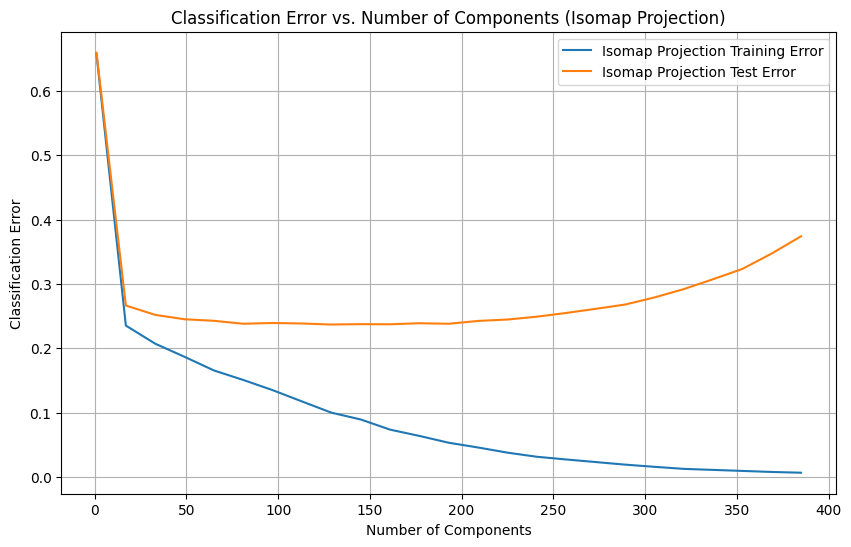

In [ ]:
# Plot classification errors vs. number of components for random projections
plt.figure(figsize=(10, 6))
plt.plot(subspace_dimensions, isomap_projection_train_errors, label='Isomap Projection Training Error')
plt.plot(subspace_dimensions, isomap_projection_test_errors, label='Isomap Projection Test Error')
plt.title('Classification Error vs. Number of Components (Isomap Projection)')
plt.xlabel('Number of Components')
plt.ylabel('Classification Error')
plt.legend()
plt.grid(True)
plt.show()


##Question 4

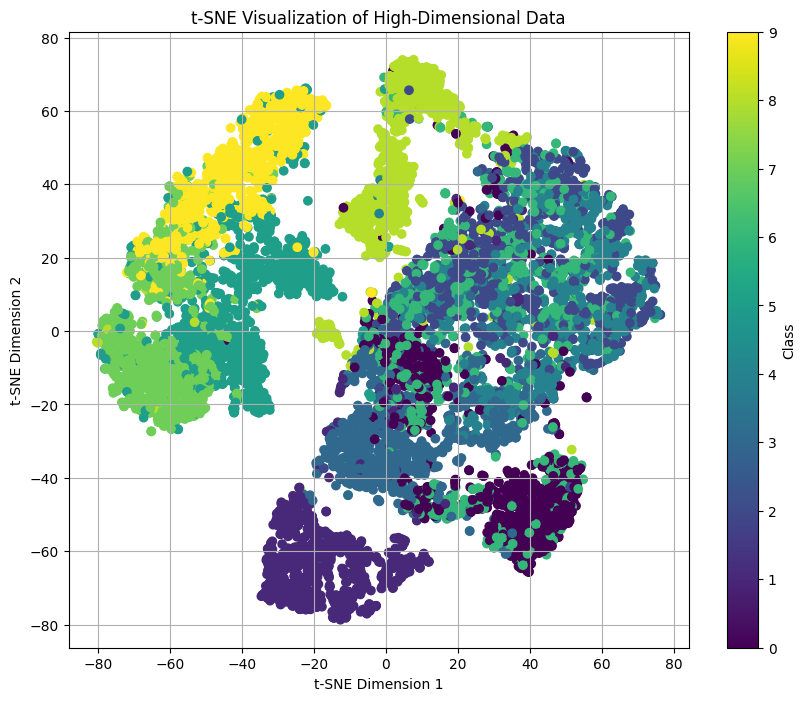

In [ ]:
# Create an instance of the t-SNE class
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)

# Fit the t-SNE model to the dataset and transform the dataset to obtain low-dimensional embeddings
tsne_embeddings = tsne.fit_transform(X)

# Visualize the scatter plot of the samples with their class information
plt.figure(figsize=(10, 8))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=y, cmap='viridis')
plt.title('t-SNE Visualization of High-Dimensional Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Class')
plt.grid(True)
plt.show()